In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import glob
from functools import partial
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv1D, MaxPooling1D, Dropout, Dense, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import tensorflow.keras
from sklearn.preprocessing import normalize

data = pd.read_csv("./CSV/Scenario-A/merged_5s.csv")
data.head()
# check missing values
data.isnull().any().value_counts()

# fill the missing values with the previous values in that row
data.fillna(method = 'ffill',inplace = True)

# check again and confirm
data.isnull().any().value_counts()

drops = [' Destination IP', 'Source IP', ' Source Port', ' Destination Port', ' Protocol']
data.drop(drops, axis=1, inplace=True)

data.shape
data.columns

nullColumns = data.columns[data.isna().any()].tolist()

data[nullColumns].isna().sum()
# dropColumn = [' Flow Bytes/s']
# data.drop(dropColumn, axis = 1, inplace = True)
data.shape

x = data.drop('label', axis = 1)
y = data['label']

print(x.shape, y.shape)

y.head()
y = pd.DataFrame(y, columns=['label'])
y.head()

print(y.groupby('label').size())

y_train = np.asarray(y)

for i in range(0, 84194):
    if(y_train[i] == "TOR"):
        y_train[i] = 1
    else:
        y_train[i] = 0
print(y_train)

y_train = np.asarray(y_train).astype(np.float64)

# check x_train array for inf values
assert not np.any(np.isnan(x))
x_train = np.asarray(x).astype(np.float64)
array_has_inf = np.isinf(x_train)

# replace inf values with zeros
x_train[~np.isfinite(x_train)] = 0
array_has_inf = np.isinf(x_train)

y = y_train.copy()
x = x_train.copy()
x.shape
y.shape

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state=10)

x_train_cnn = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test_cnn = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

y_train_cnn = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
y_test_cnn = y_test.reshape(y_test.shape[0], y_train.shape[1], 1)

# cnn model
model = Sequential()
num_classes = 2
model.add(Conv1D(filters=64, kernel_size=3, activation='tanh', input_shape=x_train_cnn.shape[1:]))
model.add(Conv1D(filters=64, kernel_size=3, activation='tanh'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='tanh'))
model.add(Dense(num_classes, activation='softmax'))
print(model.summary())

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

result = model.fit(x_train_cnn, y_train_cnn, verbose=1, epochs=10, batch_size=32,
                   validation_data=(x_test_cnn, y_test_cnn))

(84194, 23) (84194,)
label
TOR       14508
nonTOR    69686
dtype: int64
[[0]
 [0]
 [0]
 ...
 [1]
 [0]
 [0]]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 21, 64)            256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 19, 64)            12352     
_________________________________________________________________
dropout (Dropout)            (None, 19, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               57700     
______________

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


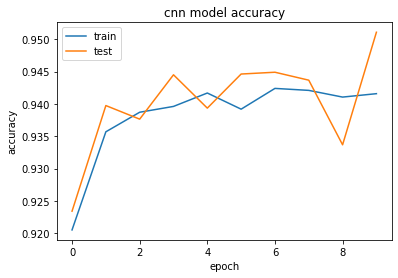

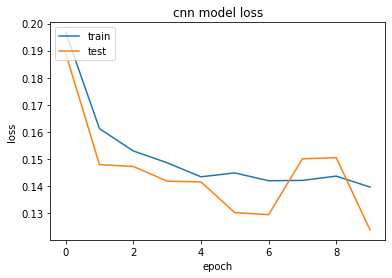

In [2]:
import matplotlib.pyplot as plt

print(result.history.keys())

# accuracy
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('cnn model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('cnn model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()